# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_5_param_1x30.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x6,17.608778,0.999338,79.678240,3.391087,0.051448,888.588117,1970.032738,2858.620855,"[-75.00741605766737, -74.95003969548506, -74.8...","[-75.00783735160118, -74.97437745626856, -74.9..."
1,1x10,15.614517,1.044416,140.417826,3.539281,0.051953,511.563751,2276.209894,2787.773645,"[-74.99419940946575, -75.02823848696148, -75.0...","[-75.01328699897375, -75.028336396094, -75.019..."
2,1x9,17.315070,1.057800,118.918062,3.516548,0.054235,766.810847,2532.620661,3299.431508,"[-75.00002849987123, -74.9800216764795, -74.92...","[-75.01243044755087, -74.97448873625879, -74.9..."


#### Original Data

In [6]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [7]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [8]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

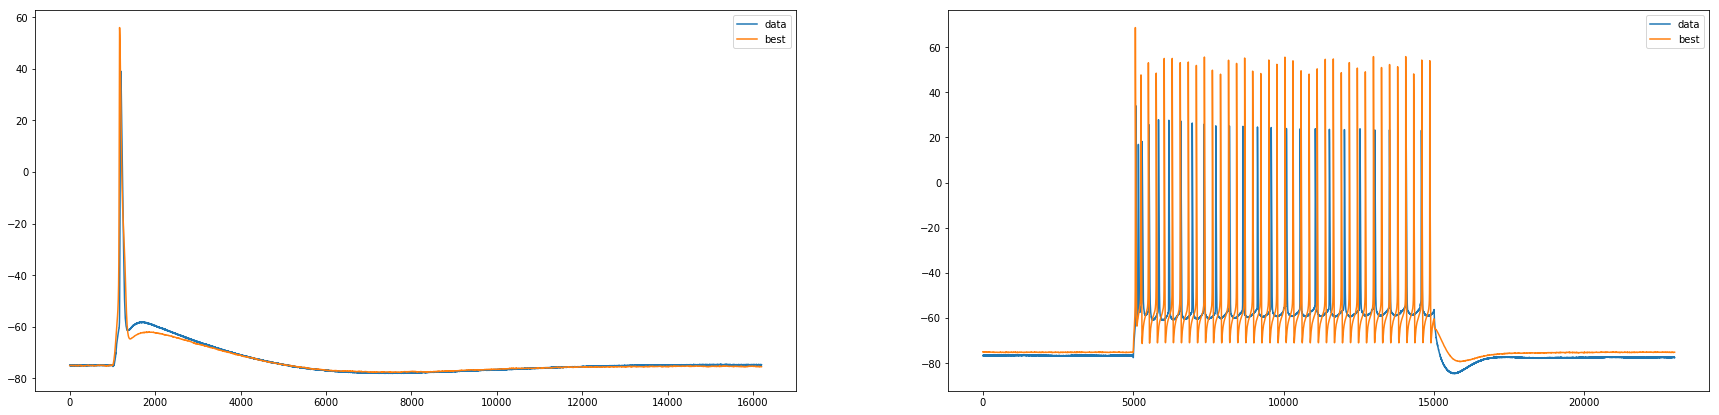

In [9]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [10]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [11]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [12]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = df_diff_ramps['sum']

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [13]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [14]:
n = 5
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [24]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
0,1x10,0.440510,0.014768,0.0,0.519565,5.044443,0.0,6.019286
11,1x32,4.206364,0.025773,6.0,1.925585,2.185906,3.0,14.343628
1,1x9,6.340919,0.031479,12.0,3.552774,5.296732,6.0,27.221904
2,1x26,5.013470,0.034119,12.0,3.630360,5.274153,6.0,25.952101
4,1x24,0.423555,0.025976,12.0,3.721739,9.078327,6.0,25.249597


In [25]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
10,1x39,0.371379,17.372671,0.04,4.499558,3.412013,2.48,0.716166,0.99,0.113281,29.995068
25,1x33,0.244982,16.906291,0.01,5.269204,4.394403,2.03,0.629819,0.81,0.273946,30.568646
7,1x12,0.745170,15.962247,0.01,5.123835,5.270966,0.42,0.598039,0.77,1.796533,30.696790
13,1x32,0.918232,15.363755,0.01,4.594775,4.898669,1.52,0.614338,0.64,2.336389,30.896158
11,1x29,0.682995,18.249137,0.04,5.779523,4.379915,0.11,0.716614,1.14,0.741237,31.839421


## Merge With DFTraces to Get the best Traces and Parameters

In [15]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [28]:
pd.merge(df_traces, df_best_steps)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
0,1x10,15.614517,1.044416,140.417826,3.539281,0.051953,511.563751,2276.209894,2787.773645,"[-74.99419940946575, -75.02823848696148, -75.0...","[-75.01328699897375, -75.028336396094, -75.019...",0.440510,0.014768,0.0,0.519565,5.044443,0.0,6.019286
1,1x9,17.315070,1.057800,118.918062,3.516548,0.054235,766.810847,2532.620661,3299.431508,"[-75.00002849987123, -74.9800216764795, -74.92...","[-75.01243044755087, -74.97448873625879, -74.9...",6.340919,0.031479,12.0,3.552774,5.296732,6.0,27.221904
2,1x26,17.030042,1.016935,120.070622,3.466972,0.051819,649.356308,2485.605262,3134.961570,"[-74.98764622358885, -74.9725152041406, -74.94...","[-74.99898250803659, -75.0046177908949, -75.01...",5.013470,0.034119,12.0,3.630360,5.274153,6.0,25.952101
3,1x24,15.139225,1.077679,149.834404,3.570745,0.051368,578.999429,2267.459632,2846.459061,"[-75.00364017542788, -75.0524415193095, -75.07...","[-74.97489550509457, -75.01204674777996, -74.9...",0.423555,0.025976,12.0,3.721739,9.078327,6.0,25.249597
4,1x32,17.362715,1.060409,134.722825,3.698470,0.052560,654.596633,2503.479722,3158.076355,"[-75.0007726404364, -74.9662285538073, -74.953...","[-75.01237837352964, -75.027623888076, -75.049...",4.206364,0.025773,6.0,1.925585,2.185906,3.0,14.343628


In [27]:
pd.merge(df_traces, df_best_steps)[names]

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x10,15.614517,1.044416,140.417826,3.539281,0.051953,"[-75.01328699897375, -75.028336396094, -75.019...","[-74.99419940946575, -75.02823848696148, -75.0..."
1,1x9,17.315070,1.057800,118.918062,3.516548,0.054235,"[-75.01243044755087, -74.97448873625879, -74.9...","[-75.00002849987123, -74.9800216764795, -74.92..."
2,1x26,17.030042,1.016935,120.070622,3.466972,0.051819,"[-74.99898250803659, -75.0046177908949, -75.01...","[-74.98764622358885, -74.9725152041406, -74.94..."
3,1x24,15.139225,1.077679,149.834404,3.570745,0.051368,"[-74.97489550509457, -75.01204674777996, -74.9...","[-75.00364017542788, -75.0524415193095, -75.07..."
4,1x32,17.362715,1.060409,134.722825,3.698470,0.052560,"[-75.01237837352964, -75.027623888076, -75.049...","[-75.0007726404364, -74.9662285538073, -74.953..."


In [17]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)[names]
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x12,16.996657,1.080635,146.054085,3.667232,0.055762,"[-75.00223382055385, -74.98553146600182, -74.9...","[-74.9996826418957, -74.9796083480469, -74.951..."
1,1x39,14.596098,1.030785,144.411113,2.970241,0.052045,"[-75.01262588090542, -74.98927191021745, -75.0...","[-74.99947529228858, -75.00044752940886, -75.0..."
2,1x29,15.116547,1.029827,167.213981,3.210267,0.044796,"[-75.00232084639178, -75.00772854702733, -75.0...","[-75.02018827000595, -75.00557652228053, -75.0..."


In [18]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x10,15.614517,1.044416,140.417826,3.539281,0.051953,"[-75.01328699897375, -75.028336396094, -75.019...","[-74.99419940946575, -75.02823848696148, -75.0..."
1,1x9,17.315070,1.057800,118.918062,3.516548,0.054235,"[-75.01243044755087, -74.97448873625879, -74.9...","[-75.00002849987123, -74.9800216764795, -74.92..."
2,1x26,17.030042,1.016935,120.070622,3.466972,0.051819,"[-74.99898250803659, -75.0046177908949, -75.01...","[-74.98764622358885, -74.9725152041406, -74.94..."


## Visualize Best Results of Given Batch

### Ramp Current

In [19]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.id

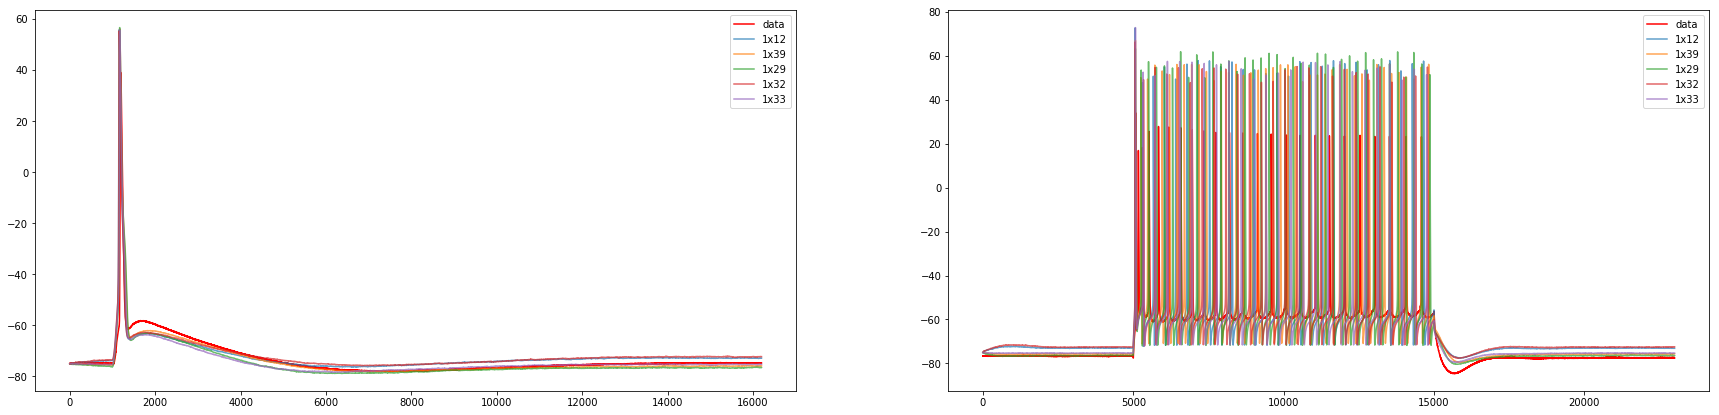

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [21]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.id

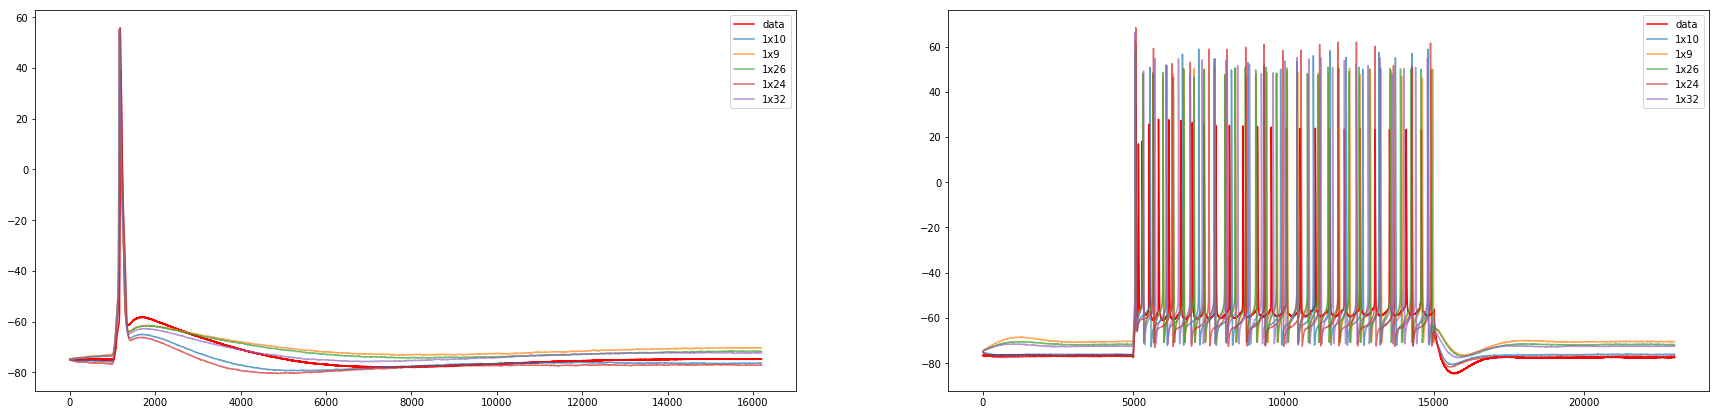

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();

